# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


# 0. Prelude

In [18]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Word cloud
Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

In [10]:
filename='hillary-clinton-emails/Emails.csv'
df = pd.read_csv(filename)
df.sample(10)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
6197,6198,C05771677,CAN YOU TALK?,H,"Berger, Samuel",192.0,2010-11-23T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0109/DOC_0C0...,F-2014-20439,...,H,Samuel Berger <,NaN,"Tuesday, November 23, 2010 9:01 AM",F-2014-20439,C05771677,08/31/2015,RELEASE IN PART,yes,UNCLASSIFIED U.S. Department of State Case No....
2821,2822,C05764537,LES GELB,H,PIR,170.0,2009-08-26T04:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_034/DOC_0C05764...,F-2014-20439,...,H; Huma Abedin; 'sullivanjj@state.gov',PIR <preines,NaN,"Wednesday, August 26, 2009 8:48 AM",F-2014-20439,C05764537,07/31/2015,RELEASE IN PART,"Yes, we're trying to find a date that works fo...",UNCLASSIFIED U.S. Department of State Case No....
6077,6078,C05771422,(AP) LEW CONFIRMED AS BUDGET DIRECTOR,H,"Huma, Abedin",81.0,2010-11-18T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0108/DOC_0C0...,F-2014-20439,...,NaN,"Abedin, Huma <AbedinH@state.gov>",SES-0_05; SES-O_Shift-III,"Thursday, November 18, 2010 9:05 PM",F-2014-20439,C05771422,08/31/2015,RELEASE IN FULL,NaN,UNCLASSIFIED U.S. Department of State Case No....
2339,2340,C05763194,MINI SCHEDULE 7/15/09,H,"Walmoro, Lona J",124.0,2009-07-15T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/AddBacks/DOC_0...,F-2014-20439,...,"H; Jiloty, Lauren C; Abedin, Huma","Valmoro, Lona J <ValmoroU@state.gov>","Valmoro, Lona J","Wednesday, July 15, 2009 7:32 AM",F-2014-20439,C05763194,06/30/2015,RELEASE IN FULL,Jack is going to chair the meeting and knows t...,UNCLASSIFIED U.S. Department of State Case No....
2172,2173,C05762864,MAJOR ECONOMIES FORUM,H,"Mills, Cheryl D",32.0,2009-04-29T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/17_18_19/DOC_0...,F-2014-20439,...,NaN,NaN,"Stern, Todd D (S/SECC)",NaN,F-2014-20439,C05762864,06/30/2015,RELEASE IN PART,"Fyi below\nMills, Cheryl D <MillsCD@state.gov>...",UNCLASSIFIED U.S. Department of State Case No....
2817,2818,C05764531,ISRAEL PM: PROGRESS MADE WITH U.S. ON SETTLEME...,H,"Mills, Cheryl D",32.0,2009-08-26T04:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_034/DOC_0C05764...,F-2014-20439,...,H,"Mills, Cheryl D <MillsCD@state.gov>",SES-O_Shift-I; SES-O_Shift-II,"Wednesday, August 26, 2009 7:28 AM",F-2014-20439,C05764531,07/31/2015,RELEASE IN FULL,NaN,UNCLASSIFIED U.S. Department of State Case No....
5311,5312,C05769994,TONIGHT,H,"Abedin, Huma",81.0,2010-06-23T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0084/DOC_0C0...,F-2014-20439,...,H; 'hanleymr@state.gov',Huma Abedin <Huma@clintonemail.com>,NaN,"Wednesday, June 23, 2010 5:39 PM",F-2014-20439,C05769994,08/31/2015,RELEASE IN PART,ok sounds good.,UNCLASSIFIED U.S. Department of State Case No....
908,909,C05760076,REFAMING THE DOMESTIC DEBATE ON SUDAN,millscd@state.gov,H,80.0,2009-11-01T04:00:00+00:00,2015-06-30T04:00:00+00:00,DOCUMENTS/HRCAll_1_1-29_JuneWEB/12_13_14/DOC_0...,F-2014-20439,...,'millscd@state.gov',H <hrod17@clintonemail.com>,"Shortley, Timothy R; Burns, William J; Steinbe...","Sunday, November 1, 2009 1:40 AM",F-2014-20439,C05760076,06/30/2015,RELEASE IN PART,Ok w me.,UNCLASSIFIED U.S. Department of State Case No....
6942,6943,C05773530,NEED A FAVOR,toivnf@state.gov,H,80.0,2010-01-25T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0117/DOC_0C0...,F-2014-20439,...,'toivnf@state.gov',H <hrod17@clintonemail.com>,"Jiloty, Lauren C <JilotyLC@state.gov>","Monday, January 25, 2010 7:16 AM",F-2014-20439,C05773530,08/31/2015,RELEASE IN FULL,Thx so much.,UNCLASSIFIED U.S. Department of State Case No....
5594,5595,C05770482,THE CA

In [145]:
raw = df['ExtractedBodyText'].dropna().reset_index()
raw_corpus = ' '.join(raw['ExtractedBodyText'])

In [146]:
from wordcloud import WordCloud

def plot_wordcloud(cloud):
    plt.figure()
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()

### 1.1 No pre-processing

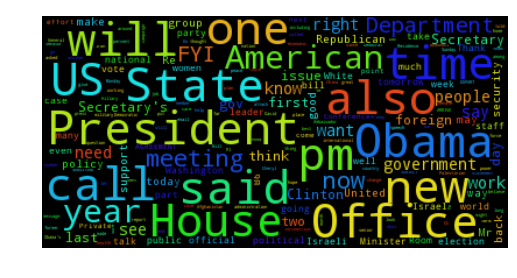

In [77]:
wordcloud = WordCloud(max_font_size=40).generate(raw_corpus)

plot_wordcloud(wordcloud)

### 1.2 Standard stemming

For this part we will use `ntlk`'s built-in Snowball stemmer and tokenizer. 

In [28]:
from nltk.stem.snowball import SnowballStemmer

stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [78]:
import re

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('^[a-zA-Z]+$', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


In [138]:
tokenized = tokenize_and_stem(raw_corpus)

In [80]:
flat_tok = ' '.join(tokenized)

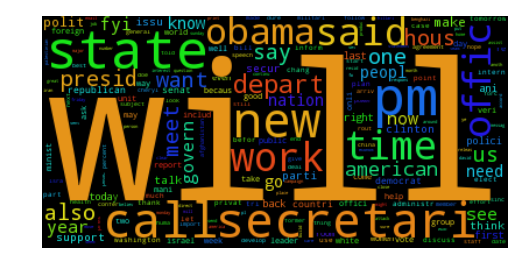

In [81]:
wordcloud_processed = WordCloud().generate(flat_tok)

plot_wordcloud(wordcloud_processed)

# 2. Sentiment analysis

Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

In [82]:
import pycountry

# 3. Topic modelling 
### 3.1 Sci-kit learn version

Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

In [95]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.externals import joblib

In [92]:
def fit_tfidf(emails):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                       min_df=0.2, stop_words=text.ENGLISH_STOP_WORDS,
                                       use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(emails)
    terms = tfidf_vectorizer.get_feature_names()
    return (terms, tfidf_matrix, tfidf_vectorizer)

In [96]:
def fit_tf(articles):
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=1000,
                                    stop_words=text.ENGLISH_STOP_WORDS)
    tf_matrix = tf_vectorizer.fit_transform(articles)
    terms = tf_vectorizer.get_feature_names()
    return (terms, tf_matrix, tf_vectorizer)

In [117]:
def run_lda(tf_matrix, tf_vectorizer):
    lda = LatentDirichletAllocation(n_topics=n_topics,
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf_matrix)
    return lda

In [127]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join(['\n + ' + str(topic[i]) + '*' + str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [91]:
print(type(raw_corpus))

<class 'str'>


In [97]:
tfidf_terms, tfidf_matrix, tfidf_vectorizer = fit_tf(raw['ExtractedBodyText'])

In [98]:
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_terms, 'tfidf_terms.pkl')

['tfidf_terms.pkl']

In [99]:
n_topics = 10; n_top_words = 20

In [118]:
lda = run_lda(tfidf_matrix, tfidf_vectorizer)

In [158]:
joblib.dump(lda, 'sklearn_lda_model.pkl')

['sklearn_lda_model.pkl',
 'sklearn_lda_model.pkl_01.npy',
 'sklearn_lda_model.pkl_02.npy',
 'sklearn_lda_model.pkl_03.npy']

In [128]:
print_top_words(lda, tfidf_terms, n_top_words)

Topic #0:

 + 256.296004302*pls 
 + 238.633932215*print 
 + 178.356853464*thank 
 + 153.938180524*koch 
 + 127.77623719*pis 
 + 86.6047152067*add 
 + 70.4246712501*fax 
 + 69.7582445507*secure 
 + 68.5047329801*speak 
 + 39.8028888905*coming 
 + 39.4749971608*sure 
 + 37.5250937124*sent 
 + 28.1236385637*soon 
 + 19.2837182355*numbers 
 + 15.3064306839*hear 
 + 10.8432831735*version 
 + 8.60784517733*discuss 
 + 8.03640413908*hours 
 + 8.02951418101*hillary 
 + 6.3255957563*meet
Topic #1:

 + 656.982975215*know 
 + 558.153659417*just 
 + 480.041426977*think 
 + 435.22715219*want 
 + 425.617145753*work 
 + 413.000579285*tomorrow 
 + 400.337322627*good 
 + 394.352757896*like 
 + 385.753198842*let 
 + 377.762436724*time 
 + 371.788236429*today 
 + 339.525340384*talk 
 + 311.485375768*ll 
 + 303.332387665*ok 
 + 291.038663525*going 
 + 286.980379793*don 
 + 256.240536066*make 
 + 227.562769691*need 
 + 227.513572332*morning 
 + 226.713983979*ve
Topic #2:

 + 682.589549869*fyi 
 + 318.40856

### 3.2 gensim version

In [153]:
from gensim import corpora, models

# This is kind of the same as the earlier tokenize_and_stem 
# but for some reason I had some issues with it (BoW wasn't accepting my tokens :()
# Source :
# https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
#

for mail in raw['ExtractedBodyText']:
    tokens = tokenizer.tokenize(mail)
    stopped_tokens = [tok for tok in tokens if not tok in text.ENGLISH_STOP_WORDS] # BAD
    stemmed_tokens = [stemmer.stem(tok) for tok in stopped_tokens]
    texts.append(stemmed_tokens)

# Create dictionary
dictionary = corpora.Dictionary(texts)
# Bag of Words
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)

In [155]:
print(ldamodel.print_topics(num_topics=20, num_words=10))

[(0, '0.019*"build" + 0.019*"offic" + 0.014*"senat" + 0.013*"number" + 0.011*"kennedi" + 0.009*"ill" + 0.008*"limit" + 0.007*"grid" + 0.007*"cell" + 0.007*"church"'), (1, '0.065*"pm" + 0.038*"s" + 0.036*"secretari" + 0.035*"offic" + 0.031*"30" + 0.028*"00" + 0.027*"depart" + 0.022*"8" + 0.022*"w" + 0.020*"10"'), (2, '0.056*"fyi" + 0.050*"no" + 0.043*"state" + 0.033*"to" + 0.030*"2015" + 0.021*"benghazi" + 0.020*"subject" + 0.020*"doc" + 0.019*"inform" + 0.018*"f"'), (3, '0.021*"i" + 0.016*"haiti" + 0.014*"work" + 0.013*"un" + 0.009*"women" + 0.008*"peopl" + 0.008*"haitian" + 0.008*"plan" + 0.007*"need" + 0.007*"issu"'), (4, '0.097*"i" + 0.014*"s" + 0.013*"work" + 0.013*"m" + 0.012*"know" + 0.011*"want" + 0.011*"we" + 0.010*"w" + 0.010*"just" + 0.010*"tomorrow"'), (5, '0.035*"ok" + 0.023*"pls" + 0.021*"print" + 0.020*"will" + 0.019*"i" + 0.018*"email" + 0.017*"can" + 0.017*"sent" + 0.016*"thx" + 0.016*"call"'), (6, '0.024*"senat" + 0.018*"koch" + 0.014*"said" + 0.012*"boehner" + 0.012*"

In [157]:
joblib.dump(ldamodel, 'gensim_lda_model.pkl')

['gensim_lda_model.pkl',
 'gensim_lda_model.pkl_01.npy',
 'gensim_lda_model.pkl_02.npy',
 'gensim_lda_model.pkl_03.npy',
 'gensim_lda_model.pkl_04.npy',
 'gensim_lda_model.pkl_05.npy',
 'gensim_lda_model.pkl_06.npy']

# 4. (bonus) Communication graph
*BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.